<h1><center>Building Spam Filter with Naive Bayes Algorithm</center></h1>

Despite simplifying assumption about independence, the algorithm works quite well in many real-word situations. Let's try to make sure of this in this project.

For this project, our goal is to create a spam filter that classifies new messages with an accuracy greater than 80% — so we expect that more than 80% of the new messages will be classified correctly as spam or ham (non-spam).

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-Libraries" data-toc-modified-id="Import-Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import Libraries</a></span></li><li><span><a href="#Exploring-the-Dataset" data-toc-modified-id="Exploring-the-Dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Exploring the Dataset</a></span></li><li><span><a href="#Split-into-Training-and-Testing-Sets" data-toc-modified-id="Split-into-Training-and-Testing-Sets-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Split into Training and Testing Sets</a></span></li><li><span><a href="#Clean-and-Preprocess-the-Data" data-toc-modified-id="Clean-and-Preprocess-the-Data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Clean and Preprocess the Data</a></span></li><li><span><a href="#Calculating-Probabilities-and-Build-Classifier" data-toc-modified-id="Calculating-Probabilities-and-Build-Classifier-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Calculating Probabilities and Build Classifier</a></span></li><li><span><a href="#Test-the-Classifier" data-toc-modified-id="Test-the-Classifier-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Test the Classifier</a></span></li><li><span><a href="#Visualize-Word-Cloud" data-toc-modified-id="Visualize-Word-Cloud-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Visualize Word Cloud</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

## Import Libraries

In [1]:
%load_ext nb_black
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from wordcloud import WordCloud

<IPython.core.display.Javascript object>

## Exploring the Dataset

In [2]:
# the data points are tab separated
messages = pd.read_csv(
    "data/SMSSpamCollection", sep="\t", header=None, names=["Label", "SMS"]
)

<IPython.core.display.Javascript object>

In [3]:
# look at columns types and number of rows
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   5572 non-null   object
 1   SMS     5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


<IPython.core.display.Javascript object>

This dataset has more than 5000 rows, and luckily for us there are no null values. It has only two columns:
- `Label` - class spam or ham (non-spam).
- `SMS` - text message.

In [4]:
# display the first five rows
messages.head()

,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


<IPython.core.display.Javascript object>

In [5]:
# display the last five rows
messages.tail()

,Label,SMS
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...
5571,ham,Rofl. Its true to its name


<IPython.core.display.Javascript object>

In [6]:
# explore main statistics
messages.describe()

,Label,SMS
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


<IPython.core.display.Javascript object>

Let's find what percentage of the messages is spam and what percentage is non-spam (ham).

In [7]:
messages["Label"].value_counts(normalize=True)

ham     0.865937
spam    0.134063
Name: Label, dtype: float64

<IPython.core.display.Javascript object>

There are about 87% non-spam messages, and remaining 13% are spam.

## Split into Training and Testing Sets

We'll keep 80% of our dataset for training, and 20% for testing. We're going to start by randomizing the entire dataset to ensure that spam and ham messages are spread properly throughout the dataset.

In [8]:
messages_randomized = messages.sample(frac=1, random_state=1)

<IPython.core.display.Javascript object>

In [9]:
# Calculate index for split
split_index = round(len(messages_randomized) * 0.8)

# spliting the data
messages_train = messages_randomized[:split_index].copy()
messages_test = messages_randomized[split_index:].copy()

<IPython.core.display.Javascript object>

Check that the percentages similar to what we have in the full dataset:

In [10]:
messages_train["Label"].value_counts(normalize=True)

ham     0.86541
spam    0.13459
Name: Label, dtype: float64

<IPython.core.display.Javascript object>

In [11]:
messages_test["Label"].value_counts(normalize=True)

ham     0.868043
spam    0.131957
Name: Label, dtype: float64

<IPython.core.display.Javascript object>

## Clean and Preprocess the Data

The next step is to use the training set to teach the algorithm to classify new messages.

Algorithm will make the classification based on the results of two equations:

$P(Spam|w_{1},w_{2},...,w_{n})∝ P(Spam)\prod \limits_{i=1}^{n} P(w_{i}|Spam)$

$P(Non-Spam|w_{1},w_{2},...,w_{n})∝ P(Non-Spam)\prod \limits_{i=1}^{n} P(w_{i}|Non-Spam)$

Also we need to calculate probabilities $P(w_{i}|Spam)$ and $P(w_{i}| Non-Spam)$:

$P(w_{i}|Spam)=\large\frac{N_{w_{i}|Spam} + \alpha}{N_{Spam} + \alpha N_{Vocabulary}} $

$P(w_{i}|Non-Spam)=\large\frac{N_{w_{i}|Non-Spam} + \alpha}{N_{Non-Spam} + \alpha N_{Vocabulary}} $

To calculate these probabilities, we need to clean and preprocess the data. We'll remove punctuation and bring all words to lower case. In addition the data must be transformed in the following format: column `SMS` will be replaced by a series of new columns, where each column represents a unique word from the vocabulary. And each row represents single message, where values in columns describe how many times each word occurs inside the message. 

In [12]:
SPAM = "spam"
HAM = "ham"

<IPython.core.display.Javascript object>

In [13]:
# remove punctuation and transform to lower case
messages_train["SMS_preprocessed"] = (
    messages_train["SMS"].str.replace(r"\W", " ", regex=True).str.lower()
)

<IPython.core.display.Javascript object>

Let's calculate $Vocabulary$ - all unique words that occur in the messages of our training set. 

In [14]:
vocabulary = messages_train["SMS_preprocessed"].str.split().values

<IPython.core.display.Javascript object>

In [15]:
# transform the vocabulary list into a set using the set() function,
# this will remove the duplicates from the vocabulary list
vocabulary = list(set(np.concatenate(vocabulary)))

<IPython.core.display.Javascript object>

In [16]:
# transform message into list of words
messages_train.loc[:, "SMS_preprocessed"] = messages_train.loc[
    :, "SMS_preprocessed"
].str.split()

<IPython.core.display.Javascript object>

We're going to create a new DataFrame `word_counts_per_sms`, where every column in the `word_counts_per_sms` represents a unique word in our `vocabulary` and each column shows the frequency of that unique word for any given message.

In [17]:
word_counts_per_sms = messages_train["SMS_preprocessed"].apply(
    lambda x: pd.Series(x).value_counts()
)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


<IPython.core.display.Javascript object>

Let's test, that everything looks as expected.

In [18]:
# check the first message
messages_train["SMS_preprocessed"].iloc[0]

['yep', 'by', 'the', 'pretty', 'sculpture']

<IPython.core.display.Javascript object>

In [19]:
# check
test = word_counts_per_sms.iloc[[0]]

# display only relevant columns
not_null_columns = test.columns[test.notnull().any()]
test[not_null_columns]

,by,pretty,sculpture,the,yep
1078,1.0,1.0,1.0,1.0,1.0


<IPython.core.display.Javascript object>

Great, now we can move on.

In [20]:
# replace NaN with 0
word_counts_per_sms.fillna(0, inplace=True)

<IPython.core.display.Javascript object>

We'll concatenate the `word_counts_per_sms` we just built above with the DataFrame containing the training set in order to have `Label` and `SMS`columns.

In [21]:
messages_train = pd.concat([messages_train, word_counts_per_sms], axis=1)

<IPython.core.display.Javascript object>

## Calculating Probabilities and Build Classifier

First of all, we'll calculate constant terms $P(Spam)$, $P(Ham)$, $N_{Spam}$, $N_{Ham}$, $N_{Vocabulary}$.

As reminder:
- $P(Spam)$ - probability of spam message
- $P(Ham)$ - probability of non-spam message
- $N_{Spam}$ - the number of the all words (not unique) in the all spam messages
- $N_{Ham}$ - the number of the all words (not unique) in the all non-spam messages
- $N_{Vocabulary}$ - the number of the all unique words in the all messages

In [22]:
# isolate the spam and the ham messages in the training set into two different DataFrames
ham_messages_train = messages_train[messages_train["Label"] == HAM].copy()
spam_messages_train = messages_train[messages_train["Label"] == SPAM].copy()

<IPython.core.display.Javascript object>

In [23]:
p_ham = ham_messages_train.shape[0] / messages_train.shape[0]

p_spam = spam_messages_train.shape[0] / messages_train.shape[0]

ham_words_number = ham_messages_train["SMS_preprocessed"].apply(len).sum()

spam_words_number = spam_messages_train["SMS_preprocessed"].apply(len).sum()

vocabulary_number = len(vocabulary)

<IPython.core.display.Javascript object>

We'll use Laplace smoothing, where $\alpha=1$.

In [24]:
# use Laplace smoothing
ALPHA = 1

<IPython.core.display.Javascript object>

We can use our training set to calculate the probability for each word in our vocabulary, thus we need to calculate both $P(w_{i}|Spam)$ and $P(w_{i}|Non-Spam)$.

Therefore, we'll calculate all probabilities before even beginning the classification of new message. Which in turn makes Naive Bayes algorithm very fast compared to other algorithms.

First, we'll initialize two dictionaries to store values for $P(w_{i}|Spam)$ and $P(w_{i}|Non-Spam)$.

In [25]:
p_ham_vocalubary = {unique_word: 0 for unique_word in vocabulary}
p_spam_vocalubary = {unique_word: 0 for unique_word in vocabulary}

<IPython.core.display.Javascript object>

Although $P(w_{i}|Spam)$ and $P(w_{i}|Non-Spam)$ vary depending on the word, the probability for each individual word is constant for every new message. To calculate these probabilities we also need to determine $N_{w_{i}|Spam}$ and  $N_{w_{i}|Non-Spam}$, which are equal to the number of times the word $w_{i}$ occurs in spam and non-spam messages respectively.

In [26]:
# calculate probabilities according to the above formulas
for unique_word in vocabulary:
    p_ham_vocalubary[unique_word] = (ham_messages_train[unique_word].sum() + ALPHA) / (
        ham_words_number + ALPHA * vocabulary_number
    )
    p_spam_vocalubary[unique_word] = (
        spam_messages_train[unique_word].sum() + ALPHA
    ) / (spam_words_number + ALPHA * vocabulary_number)

<IPython.core.display.Javascript object>

Now that we've calculated all the constants and parameters we need, we can start creating the spam filter. The spam filter can be understood as a function that takes in as input a new message, calculates probabilities and compares these values in order to classify new message as spam or non-spam.

Note that some new messages might contain words that are not part of the vocabulary. We can simply ignore these words when we're calculating the probabilities.

In [27]:
def process_message(message):
    """Removes the punctuation and brings all
    the words to lower case in the message.

    Args:
       message (str): Raw text message which needs to preprocess.

    Returns:
       list: Message split into a list of lower case words without punctuation.
    """
    message = re.sub("\W", " ", message)
    message = message.lower().split()
    return message


def calculate_probability(message, category):
    """Calculates probability P(category|message).
    The message must be pre-processed.

    Args:
       message (list): A list of words that make up the message.
       category (str): The category should be `spam` or `ham`.

    Returns:
       float: Calculated probability.

    """

    if category == SPAM:
        probability = p_spam
        for word in message:
            if word in p_spam_vocalubary:
                probability *= p_spam_vocalubary[word]

    if category == HAM:
        probability = p_ham
        for word in message:
            if word in p_ham_vocalubary:
                probability *= p_ham_vocalubary[word]

    return probability


def classify(message):
    """Performs data cleaning on string `message` and then
    classifies category, which message belongs to.

    Args:
       message (str): Raw text message which needs to preprocess and classify.

    Returns:
       str: A classification label `spam` or `ham`. If probabilities are equal,
         then reurns `needs human classification`.

    """
    message = process_message(message)

    p_spam_given_message = calculate_probability(message, SPAM)
    p_ham_given_message = calculate_probability(message, HAM)

    if p_ham_given_message > p_spam_given_message:
        return HAM
    elif p_ham_given_message < p_spam_given_message:
        return SPAM
    else:
        return "needs human classification"

<IPython.core.display.Javascript object>

## Test the Classifier

Now we can use `classify()` function to categorize messages. First, let's test the function. We take the one that is obviously spam message, and the another is obviously ham.

In [28]:
classify("WINNER!! This is the secret code to unlock the money: C3421.")

'spam'

<IPython.core.display.Javascript object>

In [29]:
classify("Sounds good, Tom, then see u there")

'ham'

<IPython.core.display.Javascript object>

Now we'll try to determine how well the spam filter does on our test set with about 1000 messages.

The algorithm will output a classification label for every message in our test set, which we'll be able to compare with the actual label.

In [30]:
messages_test.loc[:, "Predicted"] = messages_test.loc[:, "SMS"].apply(classify)

<IPython.core.display.Javascript object>

Now we can measure how good our spam filter is with classifying new messages. As we mentioned before we'll use accuracy as a metric:
$\Large accuracy=\frac{number\; of\; correctly\; classified\; messages}{total\; number\; of\; classified\; messages}$

In [31]:
total = messages_test.shape[0]
correct = (messages_test["Predicted"] == messages_test["Label"]).sum()

accuracy = correct / total * 100

<IPython.core.display.Javascript object>

In [32]:
accuracy

98.74326750448833

<IPython.core.display.Javascript object>

Accuracy is about 98%, it's better than we expected.

It's interesting to look at messages, which were classified incorrectly and try to figure out why.

In [33]:
# change maximum width of column to unlimited
pd.set_option("display.max_colwidth", None)

# incorrect messages
messages_test[messages_test["Predicted"] != messages_test["Label"]].sort_values(
    by="Label"
)

,Label,SMS,Predicted
3890,ham,Unlimited texts. Limited minutes.,spam
991,ham,26th OF JULY,spam
4862,ham,Nokia phone is lovly..,spam
2370,ham,"A Boy loved a gal. He propsd bt she didnt mind. He gv lv lttrs, Bt her frnds threw thm. Again d boy decided 2 aproach d gal , dt time a truck was speeding towards d gal. Wn it was about 2 hit d girl,d boy ran like hell n saved her. She asked 'hw cn u run so fast?' D boy replied ""Boost is d secret of my energy"" n instantly d girl shouted ""our energy"" n Thy lived happily 2gthr drinking boost evrydy Moral of d story:- I hv free msgs:D;): gud ni8",needs human classification
326,ham,No calls..messages..missed calls,spam
5046,ham,"We have sent JD for Customer Service cum Accounts Executive to ur mail id, For details contact us",spam
3460,spam,Not heard from U4 a while. Call me now am here all night with just my knickers on. Make me beg for it like U did last time 01223585236 XX Luv Nikiyu4.net,ham
1940,spam,More people are dogging in your area now. Call 09090204448 and join like minded guys. Why not arrange 1 yourself. There's 1 this evening. A£1.50 minAPN LS278BB,ham
3864,spam,"Oh my god! I've found your number again! I'm so glad, text me back xafter this msgs cst std ntwk chg £1.50",ham
4676,spam,"Hi babe its Chloe, how r u? I was smashed on saturday night, it was great! How was your weekend? U been missing me? SP visionsms.com Text stop to stop 150p/text",ham


<IPython.core.display.Javascript object>

There are only 14 incorrect labeled messages. By inspecting the above table, we obtained the following information - it seems, that currency sign and presence of web address might signal that new message could be spam. On the other hand, if message contains such words as `contact`, `unlimited`, `calls` and message is short enough, this increases the chances of being marked as spam.

## Visualize Word Cloud

Let's illustrate what words and bigrams are the most popular in spam and non-spam messages.The word cloud is perfect for such representation.

In [34]:
# list of words is needed to be converted in text for generating word cloud
spam_text = " ".join(spam_messages_train["SMS_preprocessed"].str.join(" "))

<IPython.core.display.Javascript object>

In [35]:
ham_text = " ".join(ham_messages_train["SMS_preprocessed"].str.join(" "))

<IPython.core.display.Javascript object>

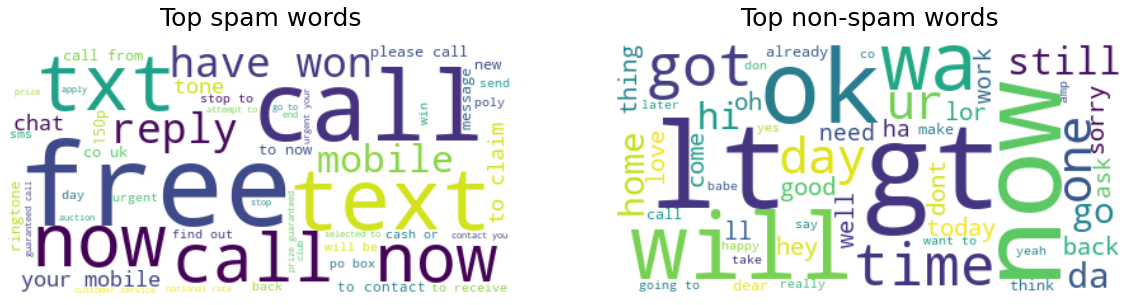

<IPython.core.display.Javascript object>

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Create and generate a word cloud image:
wordcloud_spam = WordCloud(max_words=50, background_color="white").generate(spam_text)
axes[0].imshow(wordcloud_spam, interpolation="bilinear")
axes[0].axis("off")
axes[0].set_title("Top spam words", fontsize=25, y=1.05)

wordcloud_ham = WordCloud(max_words=50, background_color="white").generate(ham_text)
axes[1].imshow(wordcloud_ham, interpolation="bilinear")
axes[1].axis("off")
axes[1].set_title("Top non-spam words", fontsize=25, y=1.05)
fig.set_title = ""

## Conclusion

In this project, we created a spam filter for SMS messages using the multinomial Naive Bayes algorithm. The filter has an accuracy of 98.74% on the test set. Despite being "naive", the algorithm shows an excellent result. 